In [1]:
import dgl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
graph = dgl.DGLGraph()
graph.add_nodes(2)
graph.add_edges((1,0),(0,1))

In [3]:
# # graph.number_of_edges()
# graph.all_edges()

In [4]:
def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

In [5]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


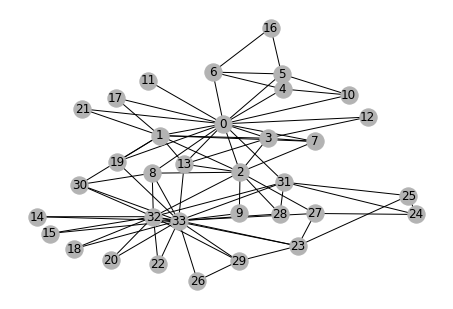

In [6]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [7]:
import torch

In [8]:
G.ndata['feat'] = torch.eye(34)

In [9]:
G

DGLGraph(num_nodes=34, num_edges=156,
         ndata_schemes={'feat': Scheme(shape=(34,), dtype=torch.float32)}
         edata_schemes={})

In [10]:
G.edges['h']

EdgeSpace(data={})

In [28]:
import torch.nn as nn
import torch.nn.functional as F

In [29]:
def gcn_message(edges):
    return {'msg' : edges.src['h']}
def gcn_reduce(nodes):
    return {'h' : torch.sum(nodes.mailbox['msg'],dim = 1)}

In [30]:
class GCNLayer(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GCNLayer,self).__init__()
        self.linear = nn.Linear(in_feats,out_feats)
    def forward(self,g,inputs):
        g.ndata['h'] = inputs
        g.send(g.edges(),gcn_message)
        g.recv(g.nodes(),gcn_reduce)
        h = g.ndata.pop('h')
        return self.linear(h)

In [37]:
# gcn = GCNLayer(1)
# node_tensor = torch.tensor([[1],[2]])
# result = gcn(graph,node_tensor)
import dgl.function as f
from time import time

In [53]:
class GCNLayerBI(nn.Module):
    def __init__(self,in_feats,out_feats):
        super(GCNLayerBI,self).__init__()
        self.linear = nn.Linear(in_feats,out_feats)
    def forward(self,g,inputs):
        g.ndata['h'] = inputs
#         g.send(g.edges(),gcn_message)
#         g.recv(g.nodes(),gcn_reduce)
        g.update_all(message_func = f.copy_src(src='h',out='out'),
                reduce_func = f.sum('out','res'))
        g.ndata['h'] = g.ndata.pop('res')
        return self.linear(g.ndata['h'])

In [54]:
class GCN(nn.Module):
    def __init__(self,in_feats,hidden_size,num_classes):
        super(GCN,self).__init__()
        self.gcn1 = GCNLayerBI(in_feats,hidden_size)
        self.gcn2 = GCNLayerBI(hidden_size, num_classes)
    def forward(self,g,inputs):
        h = self.gcn1(g,inputs)
        h = torch.relu(h)
        h = self.gcn2(g,h)
        return h

In [55]:
net = GCN(34, 5, 2)

In [56]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0,33])
labels = torch.tensor([0,1])
a = labels.detach()

In [38]:
optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)
all_logits = []
start = time()
for epoch in range(1000):
    logits = net(G,inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch %d | Loss: %.4f' %(epoch,loss.item()))
print(time() - start)

Epoch 0 | Loss: 0.0000
Epoch 1 | Loss: 0.0000
Epoch 2 | Loss: 0.0000
Epoch 3 | Loss: 0.0000
Epoch 4 | Loss: 0.0000
Epoch 5 | Loss: 0.0000
Epoch 6 | Loss: 0.0000
Epoch 7 | Loss: 0.0000
Epoch 8 | Loss: 0.0000
Epoch 9 | Loss: 0.0000
Epoch 10 | Loss: 0.0000
Epoch 11 | Loss: 0.0000
Epoch 12 | Loss: 0.0000
Epoch 13 | Loss: 0.0000
Epoch 14 | Loss: 0.0000
Epoch 15 | Loss: 0.0000
Epoch 16 | Loss: 0.0000
Epoch 17 | Loss: 0.0000
Epoch 18 | Loss: 0.0000
Epoch 19 | Loss: 0.0000
Epoch 20 | Loss: 0.0000
Epoch 21 | Loss: 0.0000
Epoch 22 | Loss: 0.0000
Epoch 23 | Loss: 0.0000
Epoch 24 | Loss: 0.0000
Epoch 25 | Loss: 0.0000
Epoch 26 | Loss: 0.0000
Epoch 27 | Loss: 0.0000
Epoch 28 | Loss: 0.0000
Epoch 29 | Loss: 0.0000
Epoch 30 | Loss: 0.0000
Epoch 31 | Loss: 0.0000
Epoch 32 | Loss: 0.0000
Epoch 33 | Loss: 0.0000
Epoch 34 | Loss: 0.0000
Epoch 35 | Loss: 0.0000
Epoch 36 | Loss: 0.0000
Epoch 37 | Loss: 0.0000
Epoch 38 | Loss: 0.0000
Epoch 39 | Loss: 0.0000
Epoch 40 | Loss: 0.0000
Epoch 41 | Loss: 0.0000
Ep

Epoch 341 | Loss: 0.0000
Epoch 342 | Loss: 0.0000
Epoch 343 | Loss: 0.0000
Epoch 344 | Loss: 0.0000
Epoch 345 | Loss: 0.0000
Epoch 346 | Loss: 0.0000
Epoch 347 | Loss: 0.0000
Epoch 348 | Loss: 0.0000
Epoch 349 | Loss: 0.0000
Epoch 350 | Loss: 0.0000
Epoch 351 | Loss: 0.0000
Epoch 352 | Loss: 0.0000
Epoch 353 | Loss: 0.0000
Epoch 354 | Loss: 0.0000
Epoch 355 | Loss: 0.0000
Epoch 356 | Loss: 0.0000
Epoch 357 | Loss: 0.0000
Epoch 358 | Loss: 0.0000
Epoch 359 | Loss: 0.0000
Epoch 360 | Loss: 0.0000
Epoch 361 | Loss: 0.0000
Epoch 362 | Loss: 0.0000
Epoch 363 | Loss: 0.0000
Epoch 364 | Loss: 0.0000
Epoch 365 | Loss: 0.0000
Epoch 366 | Loss: 0.0000
Epoch 367 | Loss: 0.0000
Epoch 368 | Loss: 0.0000
Epoch 369 | Loss: 0.0000
Epoch 370 | Loss: 0.0000
Epoch 371 | Loss: 0.0000
Epoch 372 | Loss: 0.0000
Epoch 373 | Loss: 0.0000
Epoch 374 | Loss: 0.0000
Epoch 375 | Loss: 0.0000
Epoch 376 | Loss: 0.0000
Epoch 377 | Loss: 0.0000
Epoch 378 | Loss: 0.0000
Epoch 379 | Loss: 0.0000
Epoch 380 | Loss: 0.0000


Epoch 691 | Loss: 0.0000
Epoch 692 | Loss: 0.0000
Epoch 693 | Loss: 0.0000
Epoch 694 | Loss: 0.0000
Epoch 695 | Loss: 0.0000
Epoch 696 | Loss: 0.0000
Epoch 697 | Loss: 0.0000
Epoch 698 | Loss: 0.0000
Epoch 699 | Loss: 0.0000
Epoch 700 | Loss: 0.0000
Epoch 701 | Loss: 0.0000
Epoch 702 | Loss: 0.0000
Epoch 703 | Loss: 0.0000
Epoch 704 | Loss: 0.0000
Epoch 705 | Loss: 0.0000
Epoch 706 | Loss: 0.0000
Epoch 707 | Loss: 0.0000
Epoch 708 | Loss: 0.0000
Epoch 709 | Loss: 0.0000
Epoch 710 | Loss: 0.0000
Epoch 711 | Loss: 0.0000
Epoch 712 | Loss: 0.0000
Epoch 713 | Loss: 0.0000
Epoch 714 | Loss: 0.0000
Epoch 715 | Loss: 0.0000
Epoch 716 | Loss: 0.0000
Epoch 717 | Loss: 0.0000
Epoch 718 | Loss: 0.0000
Epoch 719 | Loss: 0.0000
Epoch 720 | Loss: 0.0000
Epoch 721 | Loss: 0.0000
Epoch 722 | Loss: 0.0000
Epoch 723 | Loss: 0.0000
Epoch 724 | Loss: 0.0000
Epoch 725 | Loss: 0.0000
Epoch 726 | Loss: 0.0000
Epoch 727 | Loss: 0.0000
Epoch 728 | Loss: 0.0000
Epoch 729 | Loss: 0.0000
Epoch 730 | Loss: 0.0000


In [58]:
optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)
all_logits = []
start = time()
for epoch in range(1000):
    logits = net(G,inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch %d | Loss: %.4f' %(epoch,loss.item()))
print(time() - start)
### 果然buildin 的方法快很多

Epoch 0 | Loss: 0.0000
Epoch 1 | Loss: 0.0000
Epoch 2 | Loss: 0.0000
Epoch 3 | Loss: 0.0000
Epoch 4 | Loss: 0.0000
Epoch 5 | Loss: 0.0000
Epoch 6 | Loss: 0.0000
Epoch 7 | Loss: 0.0000
Epoch 8 | Loss: 0.0000
Epoch 9 | Loss: 0.0000
Epoch 10 | Loss: 0.0000
Epoch 11 | Loss: 0.0000
Epoch 12 | Loss: 0.0000
Epoch 13 | Loss: 0.0000
Epoch 14 | Loss: 0.0000
Epoch 15 | Loss: 0.0000
Epoch 16 | Loss: 0.0000
Epoch 17 | Loss: 0.0000
Epoch 18 | Loss: 0.0000
Epoch 19 | Loss: 0.0000
Epoch 20 | Loss: 0.0000
Epoch 21 | Loss: 0.0000
Epoch 22 | Loss: 0.0000
Epoch 23 | Loss: 0.0000
Epoch 24 | Loss: 0.0000
Epoch 25 | Loss: 0.0000
Epoch 26 | Loss: 0.0000
Epoch 27 | Loss: 0.0000
Epoch 28 | Loss: 0.0000
Epoch 29 | Loss: 0.0000
Epoch 30 | Loss: 0.0000
Epoch 31 | Loss: 0.0000
Epoch 32 | Loss: 0.0000
Epoch 33 | Loss: 0.0000
Epoch 34 | Loss: 0.0000
Epoch 35 | Loss: 0.0000
Epoch 36 | Loss: 0.0000
Epoch 37 | Loss: 0.0000
Epoch 38 | Loss: 0.0000
Epoch 39 | Loss: 0.0000
Epoch 40 | Loss: 0.0000
Epoch 41 | Loss: 0.0000
Ep

Epoch 438 | Loss: 0.0000
Epoch 439 | Loss: 0.0000
Epoch 440 | Loss: 0.0000
Epoch 441 | Loss: 0.0000
Epoch 442 | Loss: 0.0000
Epoch 443 | Loss: 0.0000
Epoch 444 | Loss: 0.0000
Epoch 445 | Loss: 0.0000
Epoch 446 | Loss: 0.0000
Epoch 447 | Loss: 0.0000
Epoch 448 | Loss: 0.0000
Epoch 449 | Loss: 0.0000
Epoch 450 | Loss: 0.0000
Epoch 451 | Loss: 0.0000
Epoch 452 | Loss: 0.0000
Epoch 453 | Loss: 0.0000
Epoch 454 | Loss: 0.0000
Epoch 455 | Loss: 0.0000
Epoch 456 | Loss: 0.0000
Epoch 457 | Loss: 0.0000
Epoch 458 | Loss: 0.0000
Epoch 459 | Loss: 0.0000
Epoch 460 | Loss: 0.0000
Epoch 461 | Loss: 0.0000
Epoch 462 | Loss: 0.0000
Epoch 463 | Loss: 0.0000
Epoch 464 | Loss: 0.0000
Epoch 465 | Loss: 0.0000
Epoch 466 | Loss: 0.0000
Epoch 467 | Loss: 0.0000
Epoch 468 | Loss: 0.0000
Epoch 469 | Loss: 0.0000
Epoch 470 | Loss: 0.0000
Epoch 471 | Loss: 0.0000
Epoch 472 | Loss: 0.0000
Epoch 473 | Loss: 0.0000
Epoch 474 | Loss: 0.0000
Epoch 475 | Loss: 0.0000
Epoch 476 | Loss: 0.0000
Epoch 477 | Loss: 0.0000


Epoch 871 | Loss: 0.0000
Epoch 872 | Loss: 0.0000
Epoch 873 | Loss: 0.0000
Epoch 874 | Loss: 0.0000
Epoch 875 | Loss: 0.0000
Epoch 876 | Loss: 0.0000
Epoch 877 | Loss: 0.0000
Epoch 878 | Loss: 0.0000
Epoch 879 | Loss: 0.0000
Epoch 880 | Loss: 0.0000
Epoch 881 | Loss: 0.0000
Epoch 882 | Loss: 0.0000
Epoch 883 | Loss: 0.0000
Epoch 884 | Loss: 0.0000
Epoch 885 | Loss: 0.0000
Epoch 886 | Loss: 0.0000
Epoch 887 | Loss: 0.0000
Epoch 888 | Loss: 0.0000
Epoch 889 | Loss: 0.0000
Epoch 890 | Loss: 0.0000
Epoch 891 | Loss: 0.0000
Epoch 892 | Loss: 0.0000
Epoch 893 | Loss: 0.0000
Epoch 894 | Loss: 0.0000
Epoch 895 | Loss: 0.0000
Epoch 896 | Loss: 0.0000
Epoch 897 | Loss: 0.0000
Epoch 898 | Loss: 0.0000
Epoch 899 | Loss: 0.0000
Epoch 900 | Loss: 0.0000
Epoch 901 | Loss: 0.0000
Epoch 902 | Loss: 0.0000
Epoch 903 | Loss: 0.0000
Epoch 904 | Loss: 0.0000
Epoch 905 | Loss: 0.0000
Epoch 906 | Loss: 0.0000
Epoch 907 | Loss: 0.0000
Epoch 908 | Loss: 0.0000
Epoch 909 | Loss: 0.0000
Epoch 910 | Loss: 0.0000


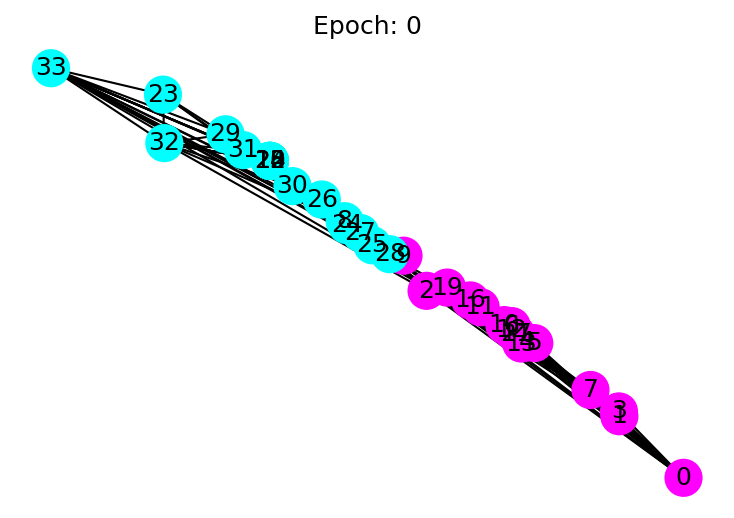

In [20]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
# plt.close()

In [76]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)